# Predict Air Pollution

#### Pedagogical objectives
- Prepare the data (for real)
- Further dig into Recurrent Neural Networks
- Stack multiple layers of RNNs

#### ML objective
- predict the **air pollution on the next day**
- given a sequence of weather features, such as the temperature, the pression, etc..
![image-2.png](attachment:image-2.png)


```

## 1. Preprocessing

### 1.1 Load and inspect data

In [8]:
import pandas as pd
df = pd.read_csv('data.txt', index_col=[0])
df = df[['pm2.5', 'TEMP', 'DEWP', 'PRES', 'Ir', 'Is', 'Iws']]
df

,pm2.5,TEMP,DEWP,PRES,Ir,Is,Iws
No,,,,,,,
1,NaN,-11.0,-21,1021.0,0,0,1.79
2,NaN,-12.0,-21,1020.0,0,0,4.92
3,NaN,-11.0,-21,1019.0,0,0,6.71
4,NaN,-14.0,-21,1019.0,0,0,9.84
5,NaN,-12.0,-20,1018.0,0,0,12.97
...,...,...,...,...,...,...,...
43820,8.0,-2.0,-23,1034.0,0,0,231.97
43821,10.0,-3.0,-22,1034.0,0,0,237.78
43822,10.0,-3.0,-22,1034.0,0,0,242.70


☝️ The data here corresponds to hourly measurements of the air pollution (feature: `pm2.5`, which is the concentration of 2.5 millimeter particles) that you will try to predict. Among the other related features, you have:
- TEMP: Temperature
- DEWP: Dew Point
- PRES: Pressure
- Ir: Cumulated hours of rain
- Iws: Cumulated wind speed
- Is: Cumulated hours of snow

❓ **Question** ❓ Plot the temporal progression of the different variables to get an intuition about the problem. How many years of data do we have? Are some feature visually correlated with the target?

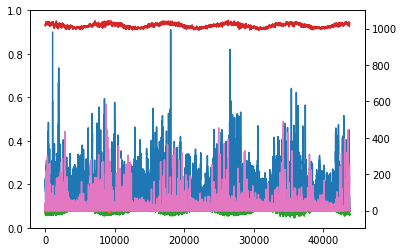

In [9]:
import matplotlib.pyplot as plt
#https://www.adamsmith.haus/python/answers/how-to-add-secondary-axis-to-a-legend-in-python
monPlot,axis=plt.subplots()
#plt.legend(monPlot, ('pm2.5	', 'TEMP', 'DEWP','PRES','Ir','Is','Iws'))
axis_2 = axis.twinx()


axis_2.plot(df)

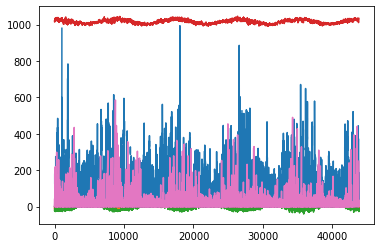

In [10]:
plt.plot(df)

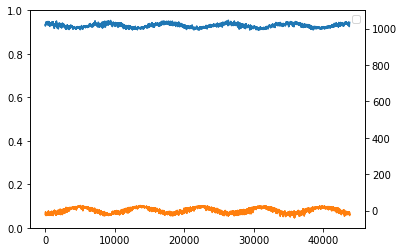

In [11]:
figure, axis_1 = plt.subplots()
axis_2 = axis_1.twinx()
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
axis_1.legend(lines, labels, loc=0)
axis_2.plot(df[['PRES','DEWP']], label="monlabel")

### 1.2 Create sequences (`X`,`y`) 

In the previous exercises, we had multiple independent data sequences. Here, you notice that there is only one. And this is quite often the case. So how to deal with such data? In fact, this long sequence can be separated in a lot of short sequences that we will consider as independent. 
![image.png](attachment:image.png)

This section aims to create a training set suitable for a RNN:
```python
X.shape = (n_sequences, length, n_features) # e.g. (100, 20, 7)
y.shape = (n_sequences, ) # e.g. (100,)
```

❓ **Question** ❓ Code the function `subsample_sequence` below such that it returns something like
![image-2.png](attachment:image-2.png)

In [12]:
import numpy as np
import random
import math

def subsample_sequence(df, length):
    ran=math.floor(random.uniform(0,len(df)-length-1))
    df_sample=df[ran:ran+length]
    print(df_sample)
    return df_sample

In [13]:
# Test it 
assert subsample_sequence(df, 10).shape == (10, 7)
assert subsample_sequence(df, 20000).shape == (20000, 7)

       pm2.5  TEMP  DEWP    PRES  Ir  Is     Iws
No                                              
16964   15.0  -3.0   -18  1040.0   0   0   87.60
16965    9.0  -4.0   -18  1041.0   0   0   96.54
16966    7.0  -4.0   -18  1041.0   0   0  104.59
16967    7.0  -5.0   -18  1042.0   0   0  111.74
16968    7.0  -5.0   -18  1042.0   0   0  119.79
16969    7.0  -7.0   -18  1042.0   0   0  123.81
16970   17.0  -8.0   -17  1041.0   0   0  127.83
16971   17.0  -7.0   -17  1041.0   0   0  131.85
16972   18.0  -8.0   -17  1041.0   0   0  134.98
16973   13.0  -6.0   -17  1040.0   0   0  142.13
       pm2.5  TEMP  DEWP    PRES  Ir  Is    Iws
No                                             
20147  109.0  13.0     7  1013.0   0   0  12.07
20148  102.0  14.0     7  1013.0   0   0  13.86
20149  102.0  14.0     8  1013.0   0   0  15.65
20150  122.0  14.0     9  1012.0   0   0  18.78
20151  125.0  15.0     9  1012.0   0   0  20.57
...      ...   ...   ...     ...  ..  ..    ...
40142  164.0  30.0    22  10

❓ **Question** ❓ Write a function that given a full dataframe `df`:
- Subsamples this dataset into a shorter sequence of length `length`
- Stores the value of the pollution of the last day as your variable array `y`
- Stores all features of previous days as a variable `X`
- Returns (`X`, `y`)


In [14]:
import numpy as np

def split_subsample_sequence(df, length):
    X_sample=subsample_sequence(df, length)
    y_sample=X_sample['pm2.5'].tail(1)
    y_sample=np.squeeze(y_sample)
    return np.array(X_sample), np.array(y_sample)

In [15]:
# Test it
(X_sample, y_sample) = split_subsample_sequence(df, 9)
print(X_sample.shape)
print(y_sample.shape)
assert X_sample.shape == (9,7)
assert y_sample.shape == ()

       pm2.5  TEMP  DEWP    PRES  Ir  Is     Iws
No                                              
11484   22.0  18.0    -4  1011.0   0   0  139.93
11485   13.0  19.0    -3  1010.0   0   0  147.08
11486   14.0  19.0    -5  1009.0   0   0  155.13
11487   15.0  20.0    -6  1008.0   0   0  162.28
11488   10.0  21.0    -7  1007.0   0   0    3.13
11489   23.0  22.0    -6  1006.0   0   0    8.94
11490   14.0  22.0    -5  1006.0   0   0   16.09
11491   12.0  20.0    -3  1006.0   0   0   19.22
11492   13.0  17.0    -1  1006.0   0   0    1.79
(9, 7)
()


🚨 There are missing values in the dataframe. Let's deal with it: 

- If the value to predict `y` is missing, the function should re-run.
- If there are missing values in the variables `X`, then it should be replaced by the mean values over the other selected hours. 
- If all the other hours are missing, then they should all be replaced by the mean value of the dataframe.

❓ **Question (HARD)** ❓ Try to update your function above taking this into account. Use the solution below if you don't find the answer.


<details>
    <summary>🆘  solution </summary>
    

```python
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()
    
    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)
        
    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)
    
    y_sample = df_subsample.iloc[length-1]['pm2.5']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values
        
    return np.array(X_sample), np.array(y_sample)
```
</details>

In [16]:

from math import isnan
'''
def split_subsample_sequence(df, length):
    X_sample=subsample_sequence(df, length)
    y_sample=X_sample['pm2.5'].tail(1)
    #y_sample=np.squeeze(y_sample)
    if(y_sample.isna().sum() > 0):
      return split_subsample_sequence(df, length)
      i=0
    for label,content in X_sample.iteritems():
      if content.isna().values.all():
        X_sample[label]=df[label].mean()
      else:
        for index,row in X_sample.iterrows() :
          if np.squeeze(row.values) != np.squeeze(row.values):
            X_sample[index]=X_sample[label].mean()

    y_sample=np.squeeze(y_sample)
    return np.array(X_sample), np.array(y_sample)
   ''' 
  

"\ndef split_subsample_sequence(df, length):\n    X_sample=subsample_sequence(df, length)\n    y_sample=X_sample['pm2.5'].tail(1)\n    #y_sample=np.squeeze(y_sample)\n    if(y_sample.isna().sum() > 0):\n      return split_subsample_sequence(df, length)\n      i=0\n    for label,content in X_sample.iteritems():\n      if content.isna().values.all():\n        X_sample[label]=df[label].mean()\n      else:\n        for index,row in X_sample.iterrows() :\n          if np.squeeze(row.values) != np.squeeze(row.values):\n            X_sample[index]=X_sample[label].mean()\n\n    y_sample=np.squeeze(y_sample)\n    return np.array(X_sample), np.array(y_sample)\n   "

In [17]:
def compute_means(X, df_mean):
    # Compute means of X
    means = X.mean()

    # Case if ALL values of at least one feature of X are NaN,
    # then reaplace with the whole df_mean
    if means.isna().sum() != 0:
        means.fillna(df_mean, inplace=True)

    return means

def split_subsample_sequence(df, length, df_mean=None):
    '''Return one single random sample (X_sample, y_sample) containing one sequence each of length `length`'''
    # Trick to save time during potential recursive calls
    if df_mean is None:
        df_mean = df.mean()

    df_subsample = subsample_sequence(df, length)

    y_sample = df_subsample.iloc[length-1]['pm2.5']
    # Case y_sample is NaN: redraw !
    if y_sample != y_sample: # A value is not equal to itself only for NaN
            X_sample, y_sample = split_subsample_sequence(df, length, df_mean) # Recursive call !!!
            return np.array(X_sample), np.array(y_sample)

    X_sample = df_subsample[0:length-1]
    # Case X_sample has some NaNs
    if X_sample.isna().sum().sum() !=0:
        X_sample = X_sample.fillna(compute_means(X_sample, df_mean))
        X_sample = X_sample.values

    return np.array(X_sample), np.array(y_sample)

In [18]:


(X_sample, y_sample) = split_subsample_sequence(df, 10)
print(X_sample.shape)
print(y_sample.shape)

       pm2.5  TEMP  DEWP    PRES  Ir  Is    Iws
No                                             
26070   21.0  -8.0   -18  1035.0   0   0  12.96
26071   19.0  -8.0   -18  1035.0   0   0  16.98
26072   25.0  -8.0   -19  1035.0   0   0  21.90
26073   31.0  -8.0   -18  1036.0   0   0  25.92
26074   23.0  -7.0   -19  1036.0   0   0  30.84
26075   22.0  -6.0   -19  1036.0   0   0  35.76
26076   25.0  -5.0   -19  1036.0   0   0  39.78
26077   36.0  -3.0   -16  1035.0   0   0   1.79
26078   38.0  -2.0   -16  1034.0   0   0   4.92
26079   32.0  -2.0   -15  1033.0   0   0   8.94
(9, 7)
()


❓ **Question** ❓ Write a last (!) function to generates an entire dataset of multiple subsamples suitable for RNN, that is, $(X, y)$ of shape:

```python
X.shape = (n_sequences, length, n_features)
y.shape = (n_sequences, )
```

In [19]:
def get_X_y(df, n_sequences, length):
    X=[]
    y=[]
    for i in range(n_sequences):
      X_samp,y_samp=split_subsample_sequence(df, length+1)
      print(X_samp.shape)
      X.append(X_samp)
      y.append(y_samp)
    X=np.array(X)
    y=np.array(y)
      

    return X, y

❓ **Question** ❓ Generate your dataset $(X, y)$ of `2000` sequences, each of `20` observations + the value of the pollution at the 21-st day to predict. That's about 40,000 observations, roughly equivalent to our dataset

In [20]:
X,y=get_X_y(df,2000, 20)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
16661  222.0  -3.0    -5  1023.0   0   0   7.60
16662  229.0  -1.0    -4  1022.0   0   0  10.73
16663  222.0  -2.0    -4  1022.0   0   0  12.52
16664  233.0  -2.0    -5  1022.0   0   0  15.65
16665  234.0  -1.0    -3  1022.0   0   0  17.44
16666  223.0   2.0    -2  1022.0   0   0  20.57
16667  203.0   3.0    -3  1023.0   0   0  24.59
16668  223.0   5.0    -4  1022.0   0   0  27.72
16669  209.0   6.0    -4  1021.0   0   0  29.51
16670  193.0   6.0    -4  1020.0   0   0  31.30
16671  200.0   7.0    -5  1019.0   0   0  33.09
16672  200.0   7.0    -5  1019.0   0   0  34.88
16673  210.0   6.0    -5  1019.0   0   0   0.89
16674  222.0   5.0    -4  1020.0   0   0   1.79
16675  250.0   3.0    -4  1020.0   0   0   0.89
16676  271.0   0.0    -5  1020.0   0   0   1.78
16677  300.0  -1.0    -4  1020.0   0   0   1.79
16678  292.0   4.0    -4  1020.0   0   0   4.92
(20, 7)
       pm2.5  TEMP  DEWP    PRES  Ir  Is    Iws
No

In [21]:
# Check your code below
print(X.shape)
print(y.shape)
print(np.isnan(X).sum())
assert X.shape == (2000, 20, 7)
assert y.shape == (2000, )
assert np.isnan(X).sum() == 0

(2000, 20, 7)
(2000,)
0


### 1.3 Train Test Split

🚨 **IMPORTANT REMARK: POTENTIAL DATA LEAKAGE** 🚨 If you split this dataset (X, y) into a training and a test set, it is much likely that some data in the train set are in the test set. Especially, you will predict data in test that are input data in train.

To avoid this situation, you should _first_ separate your initial dataframe `df` into a training dataframe and test dataframe as below

![image.png](attachment:image.png)


❓ **Question** ❓ Let's not cross-validate in this challenge to start with 🤯 
- Separate `df` into `df_train` and `df_test` such that the first 80% of the dataframe are in the training, and the last 20% in the test set.
- Then generate (`X_train`, `y_train`) from `df_train` and (`X_test`, `y_test`) from `df_test`
- Ensure that `X_train.shape == (2000, 20, 7)`

In [22]:
from sklearn.model_selection import train_test_split

df_train,df_test=train_test_split(df,test_size=0.2)
X_train,y_train=get_X_y(df_train,2000,20)
X_test,y_test=get_X_y(df_test,2000,20)


Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
(20, 7)
       pm2.5  TEMP  DEWP    PRES  Ir  Is     Iws
No                                              
947    176.0   2.0   -15  1025.0   0   0    8.04
34903  254.0  -8.0   -12  1028.0   0   0   13.87
25221   20.0   6.0    -5  1021.0   0   0   40.67
15067   32.0  21.0     3  1016.0   0   0    4.92
37833   31.0  13.0     8  1021.0   0   0    6.26
7341     NaN  10.0    -6  1024.0   0   0   24.58
3934    35.0  19.0    17  1004.0   5   0    7.15
17508  130.0   2.0   -13  1029.0   0   0    4.02
4950   211.0  26.0    24  1008.0   0   0    1.79
21064  136.0  31.0    15  1007.0   0   0   31.74
7611    23.0   0.0    -8  1035.0   0   0  177.06
27457   19.0   0.0   -16  1027.0   0   0   10.28
2198    13.0  11.0   -20  1021.0   0   0   69.28
21664    NaN  32.0    18  1002.0   0   0    5.37
6204   247.0  25.0    20  1011.0   0   0   77.35
557      NaN  -9.0   -14  1019.0   0   0    4.47
35529   11.0  -2.0   -21  1029.0

In [23]:
print(X_train.shape)
assert X_train.shape == (2000, 20, 7)

(2000, 20, 7)


In [24]:
print(y.shape)

(2000,)


## 2. Predict pollution !

❓ **Question** ❓ First, what is your benchmark prediction to beat?  
Let's measure our performance in terms of *Mean Absolute Percentage Error (MAPE)* for this Time Serie challenge!

In [25]:
from statistics import mean

def benchmark(X,y):

  tot=0
  i=0
  y=np.squeeze(y)
  for target in y:
      tot+=abs(np.mean(X[i,0:,0])-target)
      y_mean=np.mean(y)
      i+=1
  return tot/i/y_mean*100


print(benchmark(X,y))

41.470986466763954


### 2.1 Simple LSTM

❓ **Question** ❓ Now, let's try here with a simple single-layer `LSTM`

- Initialize a model the way you want and compile it within the `init_model` function.
- Then, **Fit** your model and evaluate it on the test data using the `mape` metric (useful in time series)

💡 Pro tips:
- Look at the scale of your feature: Scale them features if needed
- Look at the scale of your target: If smaller than usual, increase the learning rate vs. default values!
- Don't forget to plot your loss history to get visual feedback

In [34]:
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Flatten
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

model=Sequential()
model.add(layers.Normalization())
#model.add(LSTM(units=20))
model.add(Dense(10,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(10,activation="relu"))
model.add(Dense(1,activation="linear"))


model.compile(optimizer='Adam',loss='mean_absolute_error',metrics ='mean_absolute_percentage_error')
EarlyStopping(monitor='val_loss',patience =1000)
model.fit(X_train,y_train,validation_split=0.2)
print(model.summary())
print(X_train.shape)
print(model.evaluate(X_train,y_train))

50/50 [==============================] - 2s 19ms/step - loss: 81.9006 - mean_absolute_percentage_error: 87.0519 - val_loss: 58.6658 - val_mean_absolute_percentage_error: 128.0445
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_8 (Normalizat  (None, 20, 7)            15        
 ion)                                                            
                                                                 
 dense_25 (Dense)            (None, 20, 10)            80        
                                                                 
 dense_26 (Dense)            (None, 20, 10)            110       
                                                                 
 dense_27 (Dense)            (None, 20, 10)            110       
                                                                 
 dense_28 (Dense)            (None, 20, 10)            110       
       

### 2.3 Stack RNN layers

❓ **Question** ❓ Now that you know how to write a recurrent architecture, let's see how to stack one.
If you want to stack multiple RNN, LSTM, GRU layers, it is very easy. Do it as if they were Dense (or any other) layers.

But don't forget: All RNN (**EXCEPT** the last one) should have the `return_sequences` set to True so that the entire sequence of predictions of a given layer is given to the next layer. Otherwise, you will only give the last prediction to the next layer.

In [27]:


model=Sequential()
model.add(layers.Normalization())
model.add(SimpleRNN(units=20))
model.add(Dense(10,activation="relu"))
model.add(Dense(1,activation="linear"))
model.compile(optimizer='Adam',loss='mean_absolute_percentage_error',metrics ='mean_absolute_percentage_error')
model.fit(X_train,y_train)
model.evaluate(X_test,y_test)

63/63 [==============================] - 0s 2ms/step - loss: 96.4012 - mean_absolute_percentage_error: 96.4012


[96.40121459960938, 96.40121459960938]

## 3. (Optional) Check effect of data size on performance

❓ **Question** ❓ Now, let's see how the performance changes depending on

- the number of days in each sequence (20+1 days in the previous example).
- the number of sequences (2000 sequences in our previous example)

For different values of temporal sequence lengths, re-split your data, run your model and evaluate its performance. We advise to wrap this analysis into the function below

In [28]:
def train_model(nb_sequences=1000, nb_days=50, plot_history=False):
    '''returns the MAPE on the train set'''
    pass ### YOUR CODE HERE